# Iris数据集

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn import datasets
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

## 数据预处理类

In [27]:
class data_processor:
    '''
    这个类负责处理数据和简单的数据可视化
    处理完的数据变成了对象的属性，随时可以调用
    输入：
    X特征值，Y目标值
    
    可完成：
    1.训练测试集分割
    2.数据标准化
    3.label转换为one hot编码
    4.one hot编码转换为label
    5.简单的可视化，观察数据情况
    '''
    def __init__(self, X, Y, features_name=None):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.features_name = list(range(len(X[0]))) if features_name is None else features_name
        self.data = pd.DataFrame(data=np.c_[np.array(X), np.array(Y)], columns=self.features_name + ['type'])
        self.n_classes = len(set(Y))
        
    @classmethod
    def label2onehot(cls, Y):
        '''
        将普通标签转为one-hot编码
        '''
        return label_binarize(Y, classes=list(range(0, len(set(Y)))))
    
    @classmethod
    def onehot2Label(cls, one_hot):
        '''
        将one-hot编码转为普通标签
        '''
        n_classes = len(one_hot[0])
        label = []
        for j in one_hot:
            for i in range(n_classes):
                if j[i]:
                    label.append(i) # 把类别加进去
                    break
        return np.array(label)
    
    def train_test_split(self, test_size=0.3, random_state=0):
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.X, self.Y, test_size=test_size, random_state=random_state, stratify = self.Y)
    
    def standard_data(self):
        '''
        将数据训练集数据进行标准化处理
        '''
        std = StandardScaler().fit(self.x_train)
        self.x_train_std = np.array(std.transform(self.x_train))
        self.x_test_std = np.array(std.transform(self.x_test))
        self.X_std = np.array(StandardScaler().fit_transform(self.X))
        
    def show_var_relationship(self):
        sns.pairplot(data=self.data, vars=self.data.columns[:len(self.features_name)], hue= 'type')

## 模型训练类

In [28]:
from sklearn.model_selection import validation_curve
class mod_train:
    '''
    这个类负责参数调优，画出指定变量的验证曲线，选择最佳参数
    '''
    def __init__(self, model, x_train, y_train):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
    
    def get_best(self,param_grid):
        '''
        5折交叉验证，返回最优参数
        '''
        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring="accuracy")  # 用均方误差mse做评价指标
        grid_search.fit(self.x_train, self.y_train)  # 训练
        print('Best params:{}, Best score: {}'.format(grid_search.best_params_, grid_search.best_score_))
        return grid_search.best_params_
        
    def validation_curve(self, param_name, param_range):
        '''
        输入想验证的参数名，参数范围，画出验证曲线
        '''
        train_scores, test_scores = validation_curve(
        self.model, self.x_train, self.y_train, param_name=param_name, param_range=param_range,
        cv=10, scoring="accuracy", n_jobs=1)
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        plt.title('Validation curve of {}'.format(param_name))
        plt.xlabel('Param range')
        plt.ylabel('Score')
        plt.semilogx(param_range, train_mean, label="Training score", color="r")
        plt.semilogx(param_range, test_mean, label="Cross-validation score",
             color="g")
        plt.legend()
        plt.show()
        

## 模型评估类

In [29]:
class mod_evaluator: 
    '''
    这个类负责评估模型：
    1.画ROC曲线（对能够输出预测概率的分类器）
    2.画混淆矩阵（根据预测值和真实值）
    3.画学习曲线
    4.在数据集上得到交叉验证的分数
    '''
    @classmethod 
    def ROC_curve(cls, y_prob, y_test):
        '''
        多分类的ROC，分别对3个类画出ROC曲线（macro）
        输入：
        y_prob -- 每个样本对应的三个类的概率
        y_test -- 真正的类别
        '''
        y_score = y_prob
        n_classes = len(set(y_test))
        y_test = data_processor.label2onehot(y_test)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        lw=2
        plt.figure()
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        
    @classmethod
    def confusion_matrix(cls, y, yp):
        '''
        输入：
        yp -- 预测值
        y -- 真实值
        
        输出：
        预测值和真实值的混淆矩阵
        '''
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y, yp) 
        plt.matshow(cm, cmap=plt.cm.Greens) 
        plt.colorbar() 
        
        for x in range(len(cm)): #数据标签
            for y in range(len(cm)):
                plt.annotate(cm[x,y], xy=(x, y), horizontalalignment='center', verticalalignment='center')

        plt.ylabel('True label') #坐标轴标签
        plt.xlabel('Predicted label') #坐标轴标签
        return plt 

    @classmethod
    def learning_curve(cls, estimator, X, Y, train_sizes=np.linspace(0.1,1.0,10), cv=None):
        '''
        画出在X，Y上的学习曲线
        '''
        train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, 
                                                                X=X, y=Y, cv=cv,train_sizes=train_sizes)
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        plt.figure()
        plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
        plt.plot(train_sizes, test_mean, color='green', linestyle='--',marker='s', markersize=5, label='validation accuracy')
        plt.grid()
        plt.xlabel('Number of training samples')
        plt.ylabel('Accuracy')
        plt.legend(loc='best')
        plt.ylim([0.5, 1.5])
        plt.xlim([train_sizes.min(), train_sizes.max()])
        plt.title('learning curve')
        plt.show()
        
    @classmethod
    def cv(cls, model, x, y, n_folds):
        '''
        对model在x,y上进行交叉验证
        '''
        scores = cross_val_score(model, x, y, scoring="accuracy", cv = n_folds)
        print('avg score of {}_folds cv: {} (std:{})'.format(n_folds, scores.mean(), scores.std()))

# 机器学习

## 数据处理及可视化

In [30]:
iris = datasets.load_iris()
X = iris.data.tolist()
Y = iris.target.tolist()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

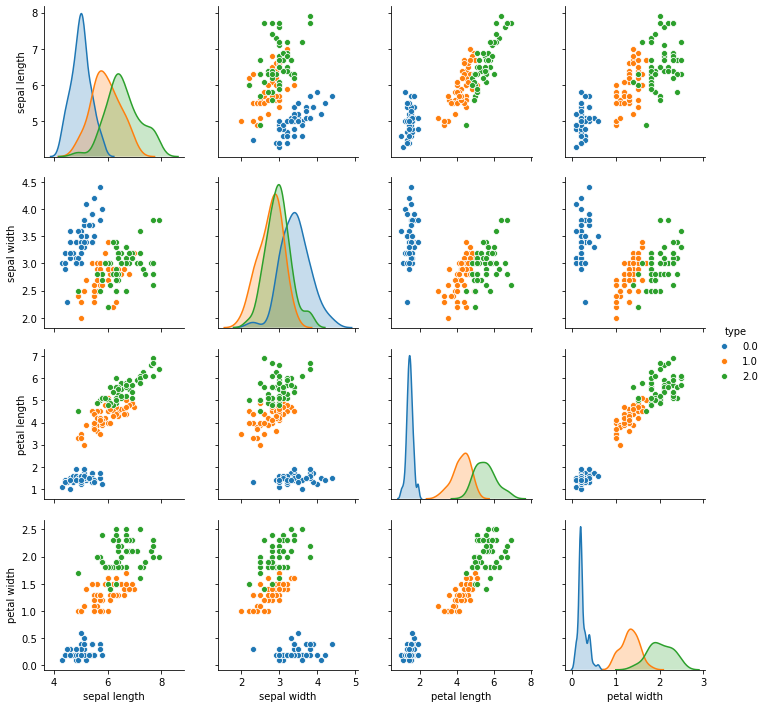

In [31]:
data = data_processor(X, Y, features_name=['sepal length', 'sepal width', 'petal length', 'petal width'])
# 划分数据集
data.train_test_split()
# 对数据进行标准化
data.standard_data()

# 简单的看一下不同变量之间的关系
data.show_var_relationship()

## SVM

### 参数调优

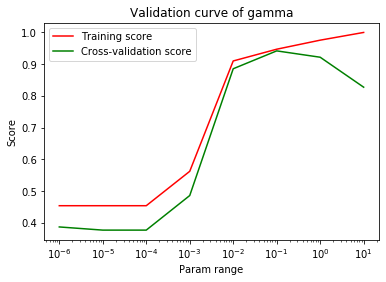

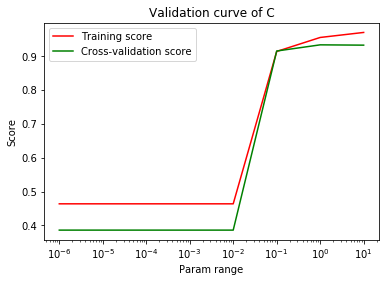

Best params:{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}, Best score: 0.9619047619047618


In [32]:
'''
基于RBF核的SVM，需要调优gamma参数和C
'''
param_range = np.logspace(-6, 1, 8)
param_grid = {'C': param_range,
              'gamma':param_range,
              'kernel':['rbf'],
              'probability':[True]
              }
        
svm_mod = mod_train(svm.SVC(), data.x_train_std, data.y_train)

# 1.gamma的验证曲线
svm_mod.validation_curve('gamma', param_range)
# 2.C的验证曲线
svm_mod.validation_curve('C', param_range)
# 得到最优参数
best_params = svm_mod.get_best(param_grid)

### 模型评估

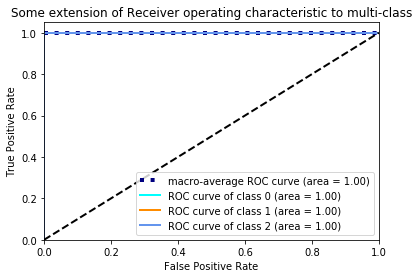

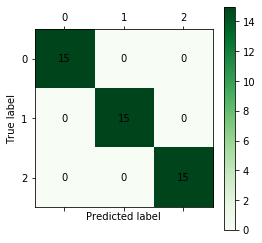

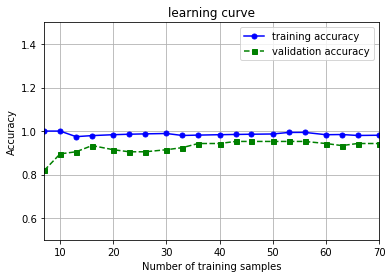

avg score of 5_folds cv: 0.9733333333333334 (std:0.03265986323710903)


In [33]:
# 导入调优后参数
svm_clf = svm.SVC(**best_params)
svm_clf.fit(data.x_train_std, data.y_train)
y_pred = svm_clf.predict(data.x_test_std)
y_prob = svm_clf.predict_proba(data.x_test_std)

# 1.ROC曲线（测试集上全预测对了）
mod_evaluator.ROC_curve(y_prob, data.y_test)
# 2.混淆矩阵
mod_evaluator.confusion_matrix(y_pred, data.y_test)
# 3.学习曲线
mod_evaluator.learning_curve(svm_clf, data.x_train_std, data.y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 20))
# 4.5折交叉验证分数
mod_evaluator.cv(svm_clf, data.X_std, data.Y, n_folds=5)

## XGB

In [34]:
import xgboost as xgb

### 参数调优

In [35]:
xgb_param_grid = {
'n_estimators':range(10,80,5),
'max_depth':range(1,5),
'learning_rate':np.linspace(0.01,0.1,10)
}

In [36]:
xgb_mod = mod_train(xgb.XGBClassifier(), data.x_train, data.y_train)
xgb_best_params = xgb_mod.get_best(xgb_param_grid)

Best params:{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10}, Best score: 0.9523809523809523


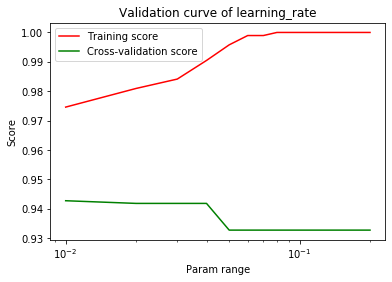

In [37]:
xgb_mod.validation_curve('learning_rate', np.linspace(0.01, 0.2, 20))

### 模型评估

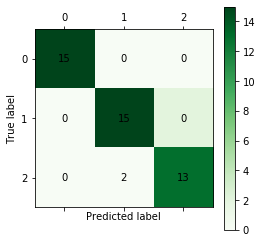

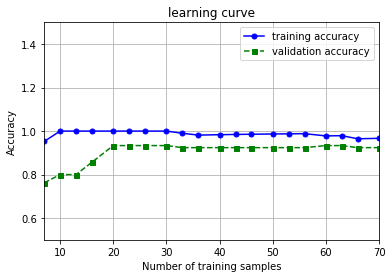

avg score of 5_folds cv: 0.9266666666666665 (std:0.05333333333333332)


In [38]:
xgb_clf = xgb.XGBClassifier(**xgb_best_params)
xgb_clf.fit(data.x_train_std, data.y_train)
y_pred = xgb_clf.predict(data.x_test_std)

# 1.混淆矩阵
mod_evaluator.confusion_matrix(y_pred, data.y_test)
# 2.学习曲线
mod_evaluator.learning_curve(xgb_clf, data.x_train_std, data.y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 20))
# 3.5折交叉验证分数
mod_evaluator.cv(xgb_clf, data.X_std, data.Y, n_folds=5)

## 逻辑回归

Best params:{'C': 200.0}, Best score: 0.980952380952381


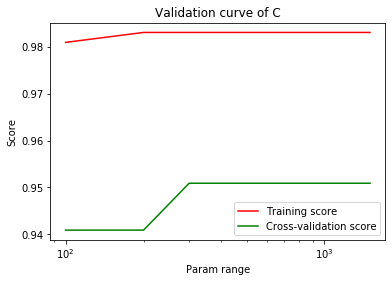

In [39]:
from sklearn.linear_model import LogisticRegression
lr_param_grid = {'C':np.linspace(100,1500,15)}
lr_mod = mod_train(LogisticRegression(max_iter=3000), data.x_train_std, data.y_train)
lr_best_params = lr_mod.get_best(lr_param_grid)
lr_mod.validation_curve('C', np.linspace(100,1500,15))

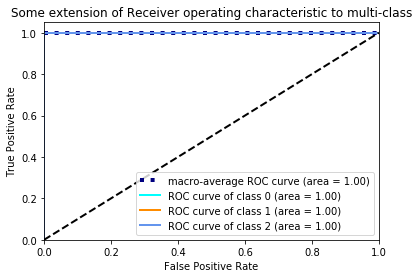

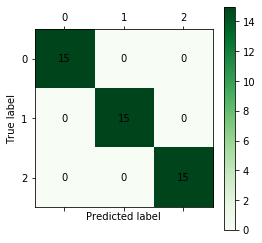

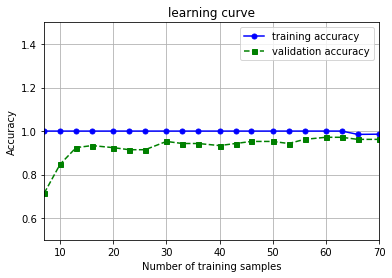

avg score of 5_folds cv: 0.9733333333333334 (std:0.03265986323710903)


In [40]:
# 导入调优后参数
lr_clf = LogisticRegression(**lr_best_params)
lr_clf.fit(data.x_train_std, data.y_train)
lr_y_pred = lr_clf.predict(data.x_test_std)
lr_y_prob = lr_clf.predict_proba(data.x_test_std)

# 1.ROC曲线
mod_evaluator.ROC_curve(lr_y_prob, data.y_test)
# 2.混淆矩阵
mod_evaluator.confusion_matrix(lr_y_pred, data.y_test)
# 4.学习曲线
mod_evaluator.learning_curve(lr_clf, data.x_train_std, data.y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 20))
# 5.5折交叉验证分数
mod_evaluator.cv(lr_clf, data.X_std, data.Y, n_folds=5)

## 集成模型

In [41]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from collections import Counter

In [42]:
def most(res):
    return np.array([Counter(i).most_common(1)[0][0] for i in res])

class AveragingModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        print(predictions)
        return most(predictions.tolist())

In [43]:
avg_clf = AveragingModels([svm_clf, xgb_clf, lr_clf])
avg_clf.fit(data.x_train_std, data.y_train)

AveragingModels(models=[SVC(C=10.0, break_ties=False, cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3, gamma=0.1,
                            kernel='rbf', max_iter=-1, probability=True,
                            random_state=None, shrinking=True, tol=0.001,
                            verbose=False),
                        XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1, ga...
                                      nthread=None, objective='multi:softprob',
                                      random_state=0, reg_alpha=0, reg_lambda=1,
                                      scale_pos_weight=1, seed=None,
                                      silent=None, subsample=1, verbosity=1),
                        LogisticRegression(C=200.0, class_weight=None,
       

In [44]:
mod_evaluator.cv(avg_clf, data.X_std, data.Y, n_folds=5)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [1 1 1]
 [1 2 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 1 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 1 2]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [2 2 2]
 [1 1 1]
 [2 2 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 2 1]
 [1 2 2]
 [1 1 1]
 [1 1 1]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [2 2 2]
 [1 1 1]
 [1 2 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [2 2 2

avg_clf将先前训练的3个模型并联在一起，将对同一个样本做出各自判断，形成三个结果，最后少数服从多数，

如 [2 1 2]说明第一个模型预测的是2，第二个模型预测的是1，第三个模型预测的是2，那么最终结果是2

从最终结果来看，集成模型在整个训练集上的表现并没有SVM和逻辑回归好，但是比其中的XGB有所提升